# Instructions :
Travail en groupe, à  placer dans le premier dépot Git de notre année Universitaire, dans le dossier <code>Computer Vision</code>.


# Membres du Groupe :

1. RANDRIAMBOLOLONIAINA Arikanto Ambinintsoa IMTICIA 4 N°04
2. RANDRIANASOLOARIVONY Mamitiana Yves ESIIA 4 N°04
3. ANDRIANIMERINA Kinasaela ESIIA 4 N°17
4. RASOANAIVO Aro Itokiana ESIIA 4 N°18
5. RAMANIRAKARISON Tolotraniaina Ishmayah ESIIA 4 N°29


# Autoencodeurs pour Images de Cercles

Dans ce notebook, nous allons générer un dataset synthétique où chaque image est une image en niveaux de gris de taille 64x64 contenant un cercle blanc (de centre et rayon aléatoires) sur fond noir. Le but est d'entraîner des autoencodeurs qui réduisent ces images dans un espace latent de dimension 3, puis les reconstruisent.

Nous étudierons deux configurations :
- Un autoencodeur entièrement connecté
- Un autoencodeur convolutionnel

Vous pourrez comparer leurs performances et discuter des compromis liés à la conception de l'espace latent.

## Étape 1 : Génération du Dataset

Nous allons générer un dataset d'images où chaque image comporte un cercle blanc de centre et de rayon aléatoires. Pour cela, nous utiliserons la bibliothèque OpenCV pour dessiner le cercle sur une image noire.

### Explication Pratique
La génération d'un dataset synthétique permet de contrôler précisément les paramètres (ici, le centre et le rayon du cercle) et de disposer d'une base simple pour expérimenter la réduction dimensionnelle via l'espace latent.

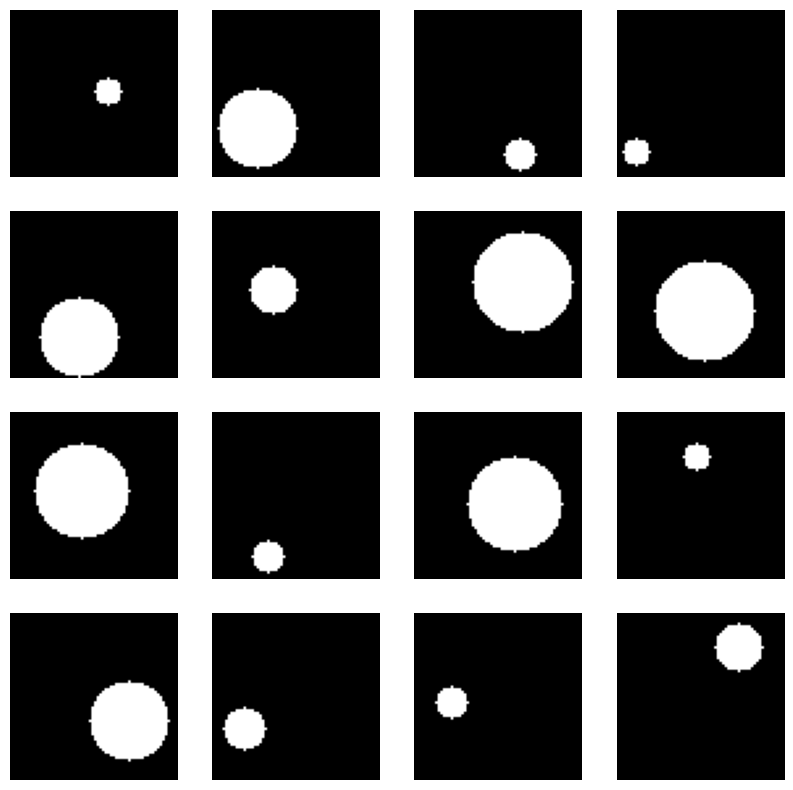

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0

    return image

def generate_dataset(n_samples=10000, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        data.append(img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# Générer le dataset
data = generate_dataset(n_samples=10000, image_size=64)

# Afficher quelques exemples
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


## Étape 2 : Préparation des Données

Nous allons diviser le dataset en ensembles d'entraînement et de test. Ici, nous utilisons 80 % des données pour l'entraînement et 20 % pour le test.

In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print('Entraînement:', train_data.shape)
print('Test:', test_data.shape)


Entraînement: (8000, 64, 64, 1)
Test: (2000, 64, 64, 1)


## Étape 3 : Autoencodeur Entièrement Connecté (Dense Layers)

Dans cette partie, nous construisons un autoencodeur entièrement connecté. Le modèle comporte :

- **Encodeur :** Un aplatissement de l'image suivi d'une couche Dense de 128 neurones (activation ReLU) puis une couche Dense de 3 neurones qui représente l'espace latent.
- **Décodeur :** Une couche Dense de 128 neurones (activation ReLU), suivie d'une couche Dense de 4096 neurones (pour reconstruire une image 64x64) avec activation sigmoïde, puis un reshape en (64,64,1).

### Explication Pratique
Cet autoencodeur simple permet de voir comment les informations (ici, la position et la taille du cercle) sont comprimées dans un espace de très faible dimension.

In [9]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)

autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_fc.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │             387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053,699 (4.02 MB)

 Trainable params: 1,053,699 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Entièrement Connecté FCN (Dense layers)

Nous allons entraîner cet autoencodeur sur l'ensemble d'entraînement.

In [10]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.4690 - val_loss: 0.1636
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1457 - val_loss: 0.1170
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1098 - val_loss: 0.0970
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0923 - val_loss: 0.0867
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0834 - val_loss: 0.0812
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0786 - val_loss: 0.0774
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0749 - val_loss: 0.0747
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0727 - val_loss: 0.0725
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0706 - val_loss: 0.0707
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0686 - val_loss: 0.0684
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0671 - val_loss: 0.0678
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0655 - val_l

### Visualisation des Reconstructions (FC)

Affichons quelques reconstructions pour évaluer qualitativement les performances de l'autoencodeur entièrement connecté.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


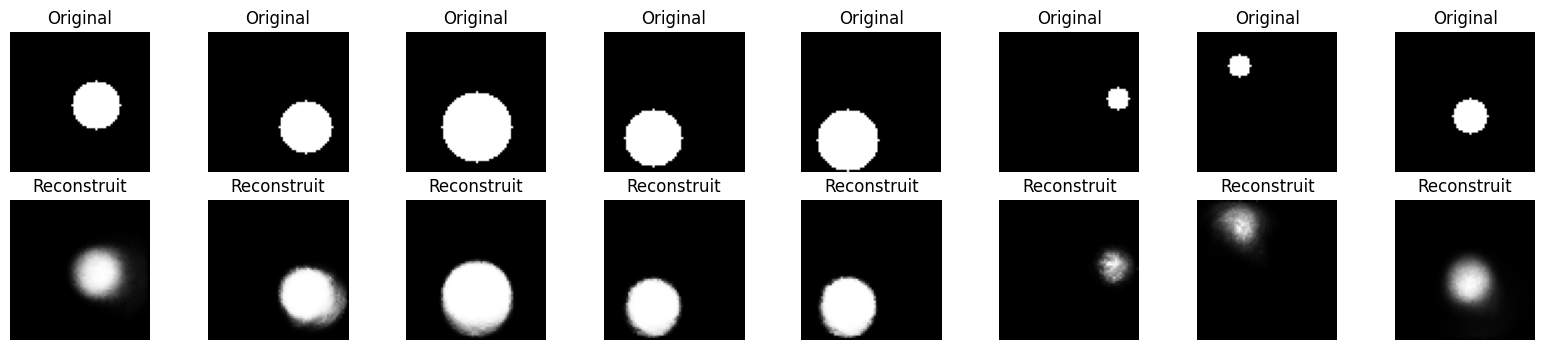

In [11]:
decoded_imgs_fc = autoencoder_fc.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Étape 4 : Autoencodeur Convolutionnel

Nous allons maintenant construire un autoencodeur convolutionnel. Cette architecture est généralement mieux adaptée pour traiter des images car elle exploite la structure spatiale.

### Architecture
- **Encodeur :**
  - Conv2D(32, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Conv2D(64, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Flatten puis Dense(3) pour obtenir le latent space
- **Décodeur :**
  - Dense(16*16*64, activation='relu') puis Reshape en (16,16,64)
  - Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')
  - Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')
  - Conv2D(1, 3, activation='sigmoid', padding='same') pour reconstruire l'image

### Explication Pratique
Les autoencodeurs convolutionnels capturent mieux la structure locale des images, ce qui peut améliorer la qualité des reconstructions par rapport à une architecture entièrement connectée.

In [12]:
input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

# Décodeur
x = layers.Dense(16*16*64, activation='relu')(latent)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_conv = models.Model(input_img, decoded)

autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │          49,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16384)               │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,188 (739.02 KB)

 Trainable params: 189,188 (739.02 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Convolutionnel

Entraînons cet autoencodeur sur le même ensemble d'entraînement.

In [13]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - loss: 0.5261 - val_loss: 0.3016
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2501 - val_loss: 0.1531
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1257 - val_loss: 0.0896
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0816 - val_loss: 0.0688
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0639 - val_loss: 0.0525
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0497 - val_loss: 0.0452
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0438 - val_loss: 0.0367
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0356 - val_loss: 0.0333
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0308 - val_loss: 0.0306
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0277 - val_loss: 0.0246
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0253 - val_loss: 0.0216
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0

### Visualisation des Reconstructions (Convolutionnel)

Affichons quelques reconstructions pour comparer qualitativement les deux architectures.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


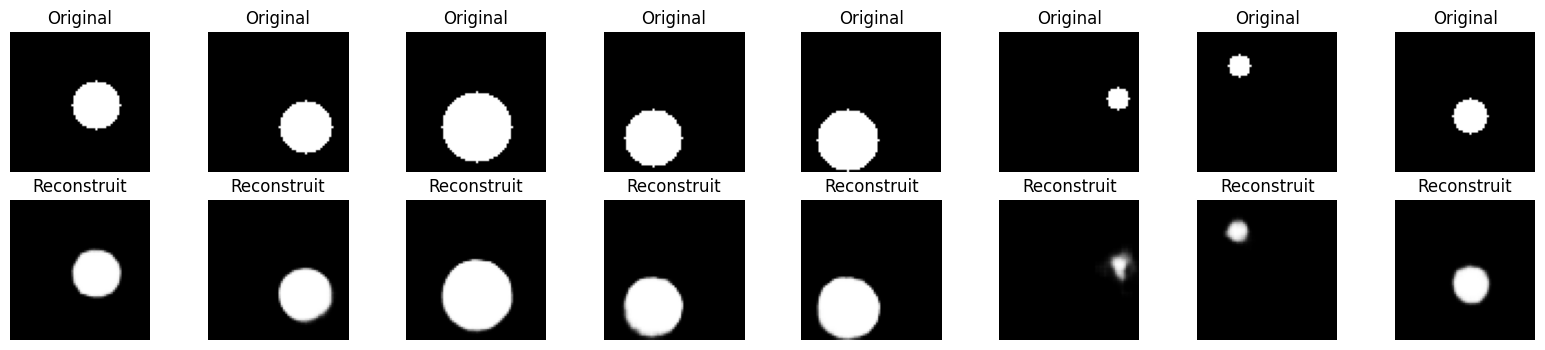

In [14]:
decoded_imgs_conv = autoencoder_conv.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Expérimentations

1. Tester les deux modèles sur des images d'entrées imparfaites (avec les imperfections de votre choix : parties cachées, bruits, ...). Interpréter les résultats.
2. Améliorer un des modèles ci-dessus de votre choix et montrer le résultat (sans modifier la taille de l'espace latent).
3. Selon les expériences menées dans ce notebook, votre avis et vos conaissances, est-il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail. **Argumenter** votre réponse.

1. Teste des deux modèles

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


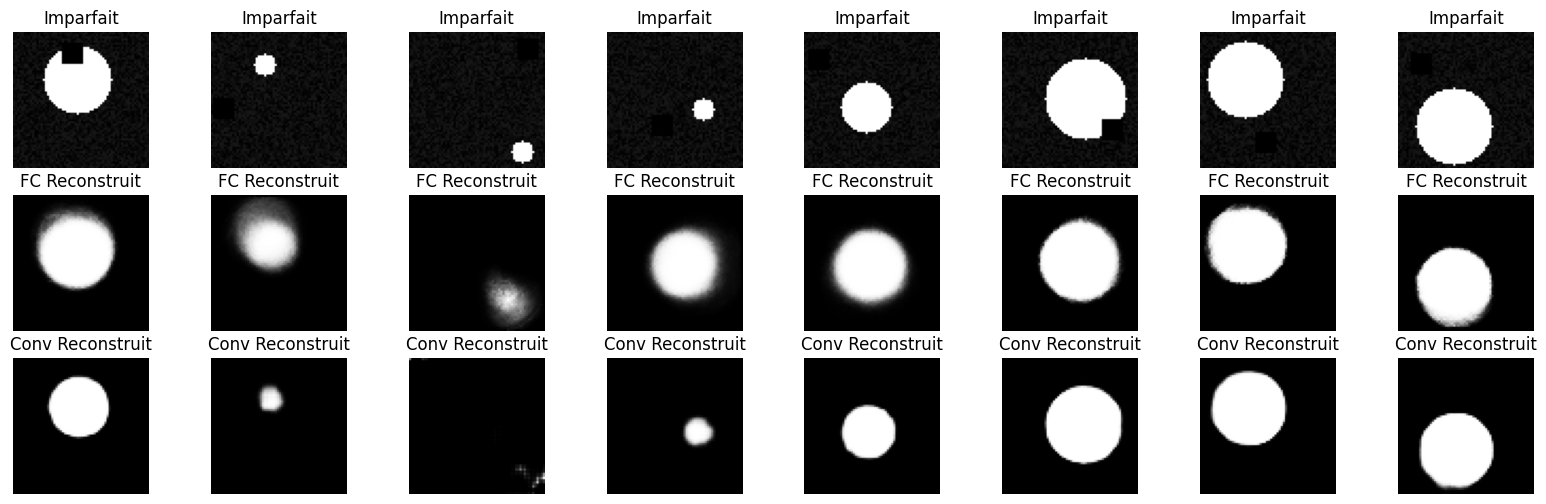

In [15]:
def generate_imperfect_circle_image(image_size=64, min_radius=5, max_radius=20, noise_level=0.1, occlusion_size=10):
    """Génère une image avec un cercle blanc imparfait."""
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    radius = np.random.randint(min_radius, max_radius)
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Ajouter du bruit aléatoire
    noise = np.random.rand(image_size, image_size) * 255 * noise_level
    image = np.clip(image + noise, 0, 255).astype(np.uint8)

    # Ajouter une occlusion rectangulaire aléatoire
    occlusion_x = np.random.randint(0, image_size - occlusion_size)
    occlusion_y = np.random.randint(0, image_size - occlusion_size)
    image[occlusion_y:occlusion_y + occlusion_size, occlusion_x:occlusion_x + occlusion_size] = 0

    image = image.astype('float32') / 255.0
    return image

def generate_imperfect_dataset(n_samples=500, image_size=64):
    data_imperfect = []
    for _ in range(n_samples):
        img = generate_imperfect_circle_image(image_size=image_size)
        data_imperfect.append(img)
    data_imperfect = np.array(data_imperfect)
    data_imperfect = np.expand_dims(data_imperfect, axis=-1)
    return data_imperfect

# Générer le dataset d'images imparfaites
imperfect_test_data = generate_imperfect_dataset(n_samples=500)

# Prédictions des deux modèles sur les données imparfaites
decoded_imgs_fc_imperfect = autoencoder_fc.predict(imperfect_test_data)
decoded_imgs_conv_imperfect = autoencoder_conv.predict(imperfect_test_data)

# Visualisation des reconstructions sur les données imparfaites
n = 8
plt.figure(figsize=(20, 6))
for i in range(n):
    # Afficher l'image originale imparfaite
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(imperfect_test_data[i].squeeze(), cmap='gray')
    plt.title('Imparfait')
    plt.axis('off')

    # Afficher la reconstruction de l'autoencodeur FC
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc_imperfect[i].squeeze(), cmap='gray')
    plt.title('FC Reconstruit')
    plt.axis('off')

    # Afficher la reconstruction de l'autoencodeur Convolutionnel
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs_conv_imperfect[i].squeeze(), cmap='gray')
    plt.title('Conv Reconstruit')
    plt.axis('off')
plt.show()

**Interpretation**

On a utilisé les imperfections qui flouttent et cache les cercles.En observant les reconstructions, on s'attend à ce que :

* L'autoencodeur entièrement connecté (FC)
aura plus de mal à reconstruire les images abîmées. Comme il traite l'image comme une longue ligne de pixels, il perd la structure de l'image et est plus sensible aux bruits ou aux parties manquantes. Les reconstructions risquent d'être floues ou mal complètes.

* L'autoencodeur convolutionnel (Conv) devrait mieux fonctionner. Les couches convolutionnelles sont faites pour capter les détails de l'image, ce qui les rend plus résistantes aux bruits ou aux parties manquantes. Les reconstructions devraient montrer un cercle plus net et les imperfections seront mieux traitées ou ignorées.

2. **Amélioration d'un des modèles**

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │          24,579 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8192)                │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 390,148 (1.49 MB)

 Trainable params: 390,148 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - loss: 0.5210 - val_loss: 0.3168
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.2949 - val_loss: 0.1738
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1485 - val_loss: 0.0970
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0846 - val_loss: 0.0634
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0590 - val_loss: 0.0481
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0434 - val_loss: 0.0415
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0335 - val_loss: 0.0312
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0276 - val_loss: 0.0408
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0256 - val_loss: 0.0218
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0190 - val_loss: 0.0186
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0181 - val_loss: 0.0194
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 

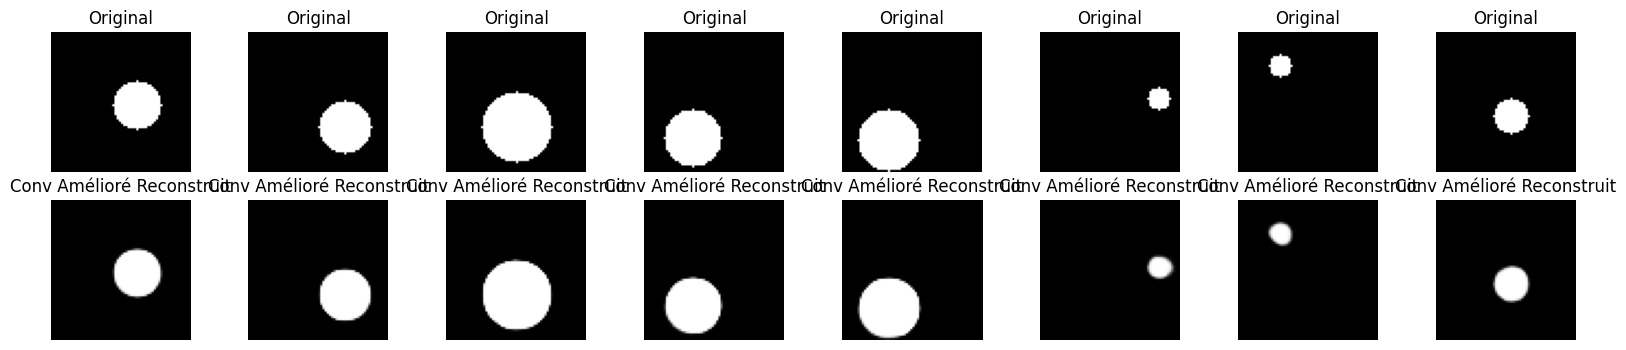

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


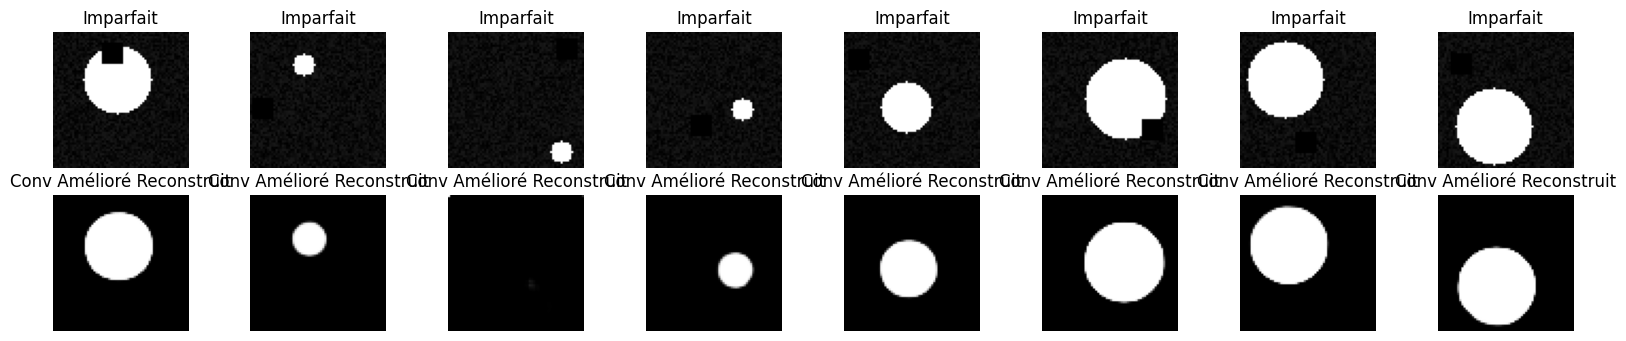

In [16]:
input_img_improved = layers.Input(shape=(64, 64, 1))

# Encodeur amélioré
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img_improved)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
latent_improved = layers.Dense(3, name='latent_space')(x)

# Décodeur amélioré
x = layers.Dense(8 * 8 * 128, activation='relu')(latent_improved)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoded_improved = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_conv_improved = models.Model(input_img_improved, decoded_improved)

autoencoder_conv_improved.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv_improved.summary()

# Entraînement du modèle amélioré
history_conv_improved = autoencoder_conv_improved.fit(train_data, train_data,
                                                    epochs=30,  # Augmenter le nombre d'epochs peut être bénéfique
                                                    batch_size=128,
                                                    shuffle=True,
                                                    validation_data=(test_data, test_data))

# Visualisation des reconstructions du modèle amélioré
decoded_imgs_conv_improved = autoencoder_conv_improved.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite par le modèle amélioré
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv_improved[i].squeeze(), cmap='gray')
    plt.title('Conv Amélioré Reconstruit')
    plt.axis('off')
plt.show()

# Visualisation sur les données imparfaites avec le modèle amélioré
decoded_imgs_conv_improved_imperfect = autoencoder_conv_improved.predict(imperfect_test_data)

n = 8
plt.figure(figsize=(20, 6))
for i in range(n):
    # Afficher l'image originale imparfaite
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(imperfect_test_data[i].squeeze(), cmap='gray')
    plt.title('Imparfait')
    plt.axis('off')

    # Afficher la reconstruction de l'autoencodeur Convolutionnel Amélioré
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv_improved_imperfect[i].squeeze(), cmap='gray')
    plt.title('Conv Amélioré Reconstruit')
    plt.axis('off')

plt.show()

3. A notre avis,il n'est pas nécessaire d'augmenter l'espace latent au-delà de 3 dimensions pour reconstruire des cercles simples, parce que :
* Les images contiennent un cercle, et pour le décrire, il suffit de connaître sa position et son rayon.
* Les modèles avec un espace latent de 3 dimensions arrivent à bien reconstruire les cercles, ce qui prouve que ces trois informations sont suffisantes.
* Si on rend l'espace latent trop grand, l'autoencodeur pourrait apprendre à mémoriser les images au lieu de comprendre les cercles. Cela ne serait pas utile, car le modèle ne capterait pas les caractéristiques essentielles des cercles.

Pour conclure, pour reconstruire des cercles simples, un espace latent de 3 dimensions est suffisant. Si les imperfections des images deviennent plus complexes, un espace plus grand pourrait être utile, mais ce n'est pas nécessaire pour ce cas précis.